# exp25: Window 1-5 CV + Window 6 Holdout + Optuna

**目的**:
- Window 1-5 で Cross Validation（ハイパーパラメータ最適化）
- Window 6 を Holdout として最終評価
- データリーケージを防止した正しい時系列評価

**構成**:
```
Window 1: Train 2017-11 ~ 2018-10 → Test 2018-11 ~ 2018-12
Window 2: Train 2017-11 ~ 2018-12 → Test 2019-01 ~ 2019-02
Window 3: Train 2017-11 ~ 2019-02 → Test 2019-03 ~ 2019-04
Window 4: Train 2017-11 ~ 2019-04 → Test 2019-05 ~ 2019-06
Window 5: Train 2017-11 ~ 2019-06 → Test 2019-07 ~ 2019-08  ← CV用
-----------------------------------------------------------
Window 6: Train 2017-11 ~ 2019-08 → Test 2019-09 ~ 2019-10  ← Holdout（最終評価）
```

**重要**: Window 6 は Optuna 最適化には使用しない

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')
import os

# 出力ディレクトリ
output_dir = '../output/exp25'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("exp25: Window 1-5 CV + Window 6 Holdout + Optuna")

exp25: Window 1-5 CV + Window 6 Holdout + Optuna


In [2]:
# ==================================================================================
# データの読み込みと特徴量作成
# ==================================================================================

def load_and_preprocess_data():
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_regime_change_features(df):
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [3]:
# ==================================================================================
# データ準備
# ==================================================================================

print("*" * 80)
print("データ準備")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")

********************************************************************************
データ準備
********************************************************************************

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [4]:
# ==================================================================================
# 特徴量（37個）
# ==================================================================================

feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'year', 
    'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_30',
    # レジーム変化特徴量
    'days_to_2019_10_01', 'is_post_2019_10_01',
    'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
]

print(f"使用する特徴量数: {len(feature_cols)}")

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()
print(f"欠損値除去後: {len(df_clean)}行")

使用する特徴量数: 33
欠損値除去後: 456行


In [5]:
# ==================================================================================
# Window設定: Window 1-5 = CV, Window 6 = Holdout
# ==================================================================================

print("\n" + "=" * 80)
print("Window設定: Window 1-5 (CV) + Window 6 (Holdout)")
print("=" * 80)

train_months = 12
test_months = 2
n_cv_windows = 5  # CV用
n_holdout_window = 6  # Holdout

# ウィンドウを生成
first_test_start = pd.Timestamp('2018-11-01')

all_windows = []
for i in range(n_holdout_window):
    test_start = first_test_start + pd.DateOffset(months=i * test_months)
    test_end = test_start + pd.DateOffset(months=test_months) - pd.Timedelta(days=1)
    train_start = test_start - pd.DateOffset(months=train_months)
    train_end = test_start - pd.Timedelta(days=1)
    
    all_windows.append({
        'window': i + 1,
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end
    })

# CV用とHoldout用に分割
cv_windows = all_windows[:n_cv_windows]  # Window 1-5
holdout_window = all_windows[n_cv_windows]  # Window 6

print("\n【CV用 Window 1-5】")
for w in cv_windows:
    print(f"  Window {w['window']}: Train {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')} | Test {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")

print("\n【Holdout Window 6】（Optunaには使用しない）")
print(f"  Window {holdout_window['window']}: Train {holdout_window['train_start'].strftime('%Y-%m-%d')} ~ {holdout_window['train_end'].strftime('%Y-%m-%d')} | Test {holdout_window['test_start'].strftime('%Y-%m-%d')} ~ {holdout_window['test_end'].strftime('%Y-%m-%d')}")


Window設定: Window 1-5 (CV) + Window 6 (Holdout)

【CV用 Window 1-5】
  Window 1: Train 2017-11-01 ~ 2018-10-31 | Test 2018-11-01 ~ 2018-12-31
  Window 2: Train 2018-01-01 ~ 2018-12-31 | Test 2019-01-01 ~ 2019-02-28
  Window 3: Train 2018-03-01 ~ 2019-02-28 | Test 2019-03-01 ~ 2019-04-30
  Window 4: Train 2018-05-01 ~ 2019-04-30 | Test 2019-05-01 ~ 2019-06-30
  Window 5: Train 2018-07-01 ~ 2019-06-30 | Test 2019-07-01 ~ 2019-08-31

【Holdout Window 6】（Optunaには使用しない）
  Window 6: Train 2018-09-01 ~ 2019-08-31 | Test 2019-09-01 ~ 2019-10-31


In [6]:
# ==================================================================================
# 評価関数
# ==================================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [7]:
# ==================================================================================
# CV用データ取得関数（リーク防止）
# ==================================================================================

def get_cv_data(df, cv_windows, feature_cols):
    """Window 1-5 のCV用データを取得"""
    cv_data = []
    
    for w in cv_windows:
        train_mask = (df['cdr_date'] >= w['train_start']) & (df['cdr_date'] <= w['train_end'])
        test_mask = (df['cdr_date'] >= w['test_start']) & (df['cdr_date'] <= w['test_end'])
        
        train_df = df[train_mask].copy()
        test_df = df[test_mask].copy()
        
        if len(train_df) == 0 or len(test_df) == 0:
            continue
        
        X_train = train_df[feature_cols]
        y_train = train_df['target_next_day']
        X_test = test_df[feature_cols]
        y_test = test_df['target_next_day']
        
        cv_data.append({
            'window': w['window'],
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        })
    
    return cv_data

def get_holdout_data(df, holdout_window, feature_cols):
    """Window 6 のHoldout用データを取得"""
    train_mask = (df['cdr_date'] >= holdout_window['train_start']) & (df['cdr_date'] <= holdout_window['train_end'])
    test_mask = (df['cdr_date'] >= holdout_window['test_start']) & (df['cdr_date'] <= holdout_window['test_end'])
    
    train_df = df[train_mask].copy()
    test_df = df[test_mask].copy()
    
    X_train = train_df[feature_cols]
    y_train = train_df['target_next_day']
    X_test = test_df[feature_cols]
    y_test = test_df['target_next_day']
    
    return X_train, y_train, X_test, y_test

# CV用データ取得
cv_data = get_cv_data(df_clean, cv_windows, feature_cols)
print(f"CV用データ: {len(cv_data)} windows")
for d in cv_data:
    print(f"  Window {d['window']}: Train {len(d['X_train'])}件, Test {len(d['X_test'])}件")

CV用データ: 5 windows
  Window 1: Train 88件, Test 43件
  Window 2: Train 131件, Test 43件
  Window 3: Train 174件, Test 43件
  Window 4: Train 217件, Test 43件
  Window 5: Train 260件, Test 45件


---
# Optuna最適化（Window 1-5 CVで評価）

In [8]:
# ==================================================================================
# Optuna最適化: Ridge
# ==================================================================================

import optuna
from sklearn.linear_model import Ridge

def objective_ridge(trial):
    """Window 1-5 の平均MAEを最小化"""
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True)
    
    mae_scores = []
    for d in cv_data:
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(d['X_train'], d['y_train'])
        pred = model.predict(d['X_test'])
        mae = mean_absolute_error(d['y_test'], pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

print("Ridge最適化開始（Window 1-5 CVで評価）")
study_ridge = optuna.create_study(direction='minimize', study_name='Ridge')
study_ridge.optimize(objective_ridge, n_trials=50, show_progress_bar=True)

print(f"\nRidge最適パラメータ: {study_ridge.best_params}")
print(f"Ridge最良CV MAE: {study_ridge.best_value:.4f}")

[I 2026-01-15 11:55:46,663] A new study created in memory with name: Ridge


Ridge最適化開始（Window 1-5 CVで評価）


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 11:55:46,726] Trial 0 finished with value: 62.166268352598664 and parameters: {'alpha': 0.002669564871412921}. Best is trial 0 with value: 62.166268352598664.
[I 2026-01-15 11:55:46,748] Trial 1 finished with value: 65.6240417795046 and parameters: {'alpha': 4.700161273135384}. Best is trial 0 with value: 62.166268352598664.
[I 2026-01-15 11:55:46,780] Trial 2 finished with value: 61.992588768600896 and parameters: {'alpha': 0.9257743745206944}. Best is trial 2 with value: 61.992588768600896.
[I 2026-01-15 11:55:46,809] Trial 3 finished with value: 61.79392883922502 and parameters: {'alpha': 0.2919643101711065}. Best is trial 3 with value: 61.79392883922502.
[I 2026-01-15 11:55:46,836] Trial 4 finished with value: 62.83498502927006 and parameters: {'alpha': 2.217426003383405}. Best is trial 3 with value: 61.79392883922502.
[I 2026-01-15 11:55:46,860] Trial 5 finished with value: 62.13857529295457 and parameters: {'alpha': 0.01565001437050636}. Best is trial 3 with value: 

In [9]:
# ==================================================================================
# Optuna最適化: ExtraTrees
# ==================================================================================

from sklearn.ensemble import ExtraTreesRegressor

def objective_extratrees(trial):
    """Window 1-5 の平均MAEを最小化"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    mae_scores = []
    for d in cv_data:
        model = ExtraTreesRegressor(**params)
        model.fit(d['X_train'], d['y_train'])
        pred = model.predict(d['X_test'])
        mae = mean_absolute_error(d['y_test'], pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

print("ExtraTrees最適化開始（Window 1-5 CVで評価）")
study_extra = optuna.create_study(direction='minimize', study_name='ExtraTrees')
study_extra.optimize(objective_extratrees, n_trials=50, show_progress_bar=True)

print(f"\nExtraTrees最適パラメータ: {study_extra.best_params}")
print(f"ExtraTrees最良CV MAE: {study_extra.best_value:.4f}")

[I 2026-01-15 11:55:48,119] A new study created in memory with name: ExtraTrees


ExtraTrees最適化開始（Window 1-5 CVで評価）


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 11:55:50,065] Trial 0 finished with value: 43.11649056165678 and parameters: {'n_estimators': 258, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 43.11649056165678.
[I 2026-01-15 11:55:51,899] Trial 1 finished with value: 55.31474413204294 and parameters: {'n_estimators': 285, 'max_depth': 7, 'min_samples_split': 36, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 43.11649056165678.
[I 2026-01-15 11:55:52,586] Trial 2 finished with value: 58.192325798634876 and parameters: {'n_estimators': 95, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 0 with value: 43.11649056165678.
[I 2026-01-15 11:55:55,636] Trial 3 finished with value: 50.847250696583124 and parameters: {'n_estimators': 448, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 43.11649056165678.
[I

In [10]:
# ==================================================================================
# Optuna最適化: HistGradientBoosting
# ==================================================================================

from sklearn.ensemble import HistGradientBoostingRegressor

def objective_hist(trial):
    """Window 1-5 の平均MAEを最小化"""
    params = {
        'max_iter': trial.suggest_int('max_iter', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0001, 10.0, log=True),
        'random_state': 42
    }
    
    mae_scores = []
    for d in cv_data:
        model = HistGradientBoostingRegressor(**params)
        model.fit(d['X_train'], d['y_train'])
        pred = model.predict(d['X_test'])
        mae = mean_absolute_error(d['y_test'], pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

print("HistGradientBoosting最適化開始（Window 1-5 CVで評価）")
study_hist = optuna.create_study(direction='minimize', study_name='HistGradientBoosting')
study_hist.optimize(objective_hist, n_trials=50, show_progress_bar=True)

print(f"\nHistGradientBoosting最適パラメータ: {study_hist.best_params}")
print(f"HistGradientBoosting最良CV MAE: {study_hist.best_value:.4f}")

[I 2026-01-15 11:57:03,393] A new study created in memory with name: HistGradientBoosting


HistGradientBoosting最適化開始（Window 1-5 CVで評価）


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 11:58:47,959] Trial 0 finished with value: 54.9270402859117 and parameters: {'max_iter': 464, 'learning_rate': 0.0012268519351724592, 'max_depth': 30, 'min_samples_leaf': 21, 'l2_regularization': 0.004160052647455953}. Best is trial 0 with value: 54.9270402859117.
[I 2026-01-15 12:00:10,047] Trial 1 finished with value: 61.19559135705937 and parameters: {'max_iter': 352, 'learning_rate': 0.0010168470014817388, 'max_depth': 24, 'min_samples_leaf': 30, 'l2_regularization': 0.0002590610123865775}. Best is trial 0 with value: 54.9270402859117.
[I 2026-01-15 12:01:16,393] Trial 2 finished with value: 62.43138510044232 and parameters: {'max_iter': 174, 'learning_rate': 0.0017903673265223215, 'max_depth': 21, 'min_samples_leaf': 29, 'l2_regularization': 0.012141320401217697}. Best is trial 0 with value: 54.9270402859117.
[I 2026-01-15 12:01:50,834] Trial 3 finished with value: 46.6827789645412 and parameters: {'max_iter': 455, 'learning_rate': 0.08018435213064712, 'max_depth': 2

In [11]:
# ==================================================================================
# Optuna最適化: CatBoost
# ==================================================================================

from catboost import CatBoostRegressor

def objective_catboost(trial):
    """Window 1-5 の平均MAEを最小化"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': 0
    }
    
    mae_scores = []
    for d in cv_data:
        model = CatBoostRegressor(**params)
        model.fit(d['X_train'], d['y_train'])
        pred = model.predict(d['X_test'])
        mae = mean_absolute_error(d['y_test'], pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

print("CatBoost最適化開始（Window 1-5 CVで評価）")
study_catboost = optuna.create_study(direction='minimize', study_name='CatBoost')
study_catboost.optimize(objective_catboost, n_trials=50, show_progress_bar=True)

print(f"\nCatBoost最適パラメータ: {study_catboost.best_params}")
print(f"CatBoost最良CV MAE: {study_catboost.best_value:.4f}")

[I 2026-01-15 13:37:55,469] A new study created in memory with name: CatBoost


CatBoost最適化開始（Window 1-5 CVで評価）


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:38:10,295] Trial 0 finished with value: 51.992756091214936 and parameters: {'iterations': 1187, 'learning_rate': 0.021166566748326912, 'depth': 4, 'l2_leaf_reg': 0.29208673765653026, 'subsample': 0.7956166947647724}. Best is trial 0 with value: 51.992756091214936.
[I 2026-01-15 13:38:23,324] Trial 1 finished with value: 48.13781543708906 and parameters: {'iterations': 1147, 'learning_rate': 0.016961669665090842, 'depth': 4, 'l2_leaf_reg': 2.8395580146116277, 'subsample': 0.550138704948898}. Best is trial 1 with value: 48.13781543708906.
[I 2026-01-15 13:38:42,854] Trial 2 finished with value: 47.35001528383142 and parameters: {'iterations': 1421, 'learning_rate': 0.007583276516065961, 'depth': 6, 'l2_leaf_reg': 0.021813141399179427, 'subsample': 0.6592041289336961}. Best is trial 2 with value: 47.35001528383142.
[I 2026-01-15 13:38:46,034] Trial 3 finished with value: 48.176759039368534 and parameters: {'iterations': 211, 'learning_rate': 0.03531147811547985, 'depth': 

In [12]:
# ==================================================================================
# 最適化結果まとめ
# ==================================================================================

print("\n" + "=" * 80)
print("Optuna最適化結果まとめ（Window 1-5 CVで最適化）")
print("=" * 80)

best_params = {
    'Ridge': study_ridge.best_params,
    'ExtraTrees': study_extra.best_params,
    'HistGradientBoosting': study_hist.best_params,
    'CatBoost': study_catboost.best_params
}

cv_scores = {
    'Ridge': study_ridge.best_value,
    'ExtraTrees': study_extra.best_value,
    'HistGradientBoosting': study_hist.best_value,
    'CatBoost': study_catboost.best_value
}

for model_name, params in best_params.items():
    print(f"\n{model_name} (CV MAE: {cv_scores[model_name]:.4f}):")
    for key, value in params.items():
        print(f"  {key}: {value}")

# パラメータを保存
import json
with open(f'{output_dir}/best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"\n保存: {output_dir}/best_params.json")


Optuna最適化結果まとめ（Window 1-5 CVで最適化）

Ridge (CV MAE: 61.7857):
  alpha: 0.2580114891035283

ExtraTrees (CV MAE: 38.4781):
  n_estimators: 264
  max_depth: 18
  min_samples_split: 19
  min_samples_leaf: 15
  max_features: None

HistGradientBoosting (CV MAE: 41.6633):
  max_iter: 240
  learning_rate: 0.01803842734133322
  max_depth: 12
  min_samples_leaf: 8
  l2_regularization: 0.041669854730158884

CatBoost (CV MAE: 43.7367):
  iterations: 1533
  learning_rate: 0.010266907851536961
  depth: 5
  l2_leaf_reg: 9.805101985786036
  subsample: 0.941609238979479

保存: ../output/exp25/best_params.json


---
# Window 6 Holdout 最終評価

In [13]:
# ==================================================================================
# Window 6 Holdout 最終評価
# ==================================================================================

from scipy.optimize import minimize

print("\n" + "=" * 80)
print("Window 6 Holdout 最終評価（Optunaで最適化したパラメータを使用）")
print("=" * 80)

# Holdoutデータ取得
X_train_ho, y_train_ho, X_test_ho, y_test_ho = get_holdout_data(df_clean, holdout_window, feature_cols)
print(f"\nHoldout Train: {len(X_train_ho)}件")
print(f"Holdout Test: {len(X_test_ho)}件")
print(f"Test期間: {holdout_window['test_start'].strftime('%Y-%m-%d')} ~ {holdout_window['test_end'].strftime('%Y-%m-%d')}")

holdout_results = []
predictions_ho = {}

# 1. Ridge
ridge = Ridge(**best_params['Ridge'], random_state=42)
ridge.fit(X_train_ho, y_train_ho)
ridge_pred = ridge.predict(X_test_ho)
ridge_metrics = evaluate_model(y_test_ho, ridge_pred)
predictions_ho['Ridge'] = ridge_pred
holdout_results.append({'model': 'Ridge', **ridge_metrics})
print(f"\nRidge Holdout MAE: {ridge_metrics['MAE']:.2f}")

# 2. ExtraTrees
extra_params = {k: v for k, v in best_params['ExtraTrees'].items()}
extra = ExtraTreesRegressor(**extra_params, random_state=42, n_jobs=-1)
extra.fit(X_train_ho, y_train_ho)
extra_pred = extra.predict(X_test_ho)
extra_metrics = evaluate_model(y_test_ho, extra_pred)
predictions_ho['ExtraTrees'] = extra_pred
holdout_results.append({'model': 'ExtraTrees', **extra_metrics})
print(f"ExtraTrees Holdout MAE: {extra_metrics['MAE']:.2f}")

# 3. HistGradientBoosting
hist = HistGradientBoostingRegressor(**best_params['HistGradientBoosting'], random_state=42)
hist.fit(X_train_ho, y_train_ho)
hist_pred = hist.predict(X_test_ho)
hist_metrics = evaluate_model(y_test_ho, hist_pred)
predictions_ho['HistGradientBoosting'] = hist_pred
holdout_results.append({'model': 'HistGradientBoosting', **hist_metrics})
print(f"HistGradientBoosting Holdout MAE: {hist_metrics['MAE']:.2f}")

# 4. CatBoost
catboost = CatBoostRegressor(**best_params['CatBoost'], random_state=42, verbose=0)
catboost.fit(X_train_ho, y_train_ho)
catboost_pred = catboost.predict(X_test_ho)
catboost_metrics = evaluate_model(y_test_ho, catboost_pred)
predictions_ho['CatBoost'] = catboost_pred
holdout_results.append({'model': 'CatBoost', **catboost_metrics})
print(f"CatBoost Holdout MAE: {catboost_metrics['MAE']:.2f}")

# 5. WeightedEnsemble（CV Window 1-5で重み最適化）
def optimize_weights_cv(cv_data, best_params):
    """CV Window 1-5 を使って重みを最適化（リーク防止）"""
    all_preds = {name: [] for name in ['Ridge', 'ExtraTrees', 'HistGradientBoosting', 'CatBoost']}
    all_y = []
    
    for d in cv_data:
        # Ridge
        m = Ridge(**best_params['Ridge'], random_state=42)
        m.fit(d['X_train'], d['y_train'])
        all_preds['Ridge'].extend(m.predict(d['X_test']))
        
        # ExtraTrees
        m = ExtraTreesRegressor(**best_params['ExtraTrees'], random_state=42, n_jobs=-1)
        m.fit(d['X_train'], d['y_train'])
        all_preds['ExtraTrees'].extend(m.predict(d['X_test']))
        
        # HistGradientBoosting
        m = HistGradientBoostingRegressor(**best_params['HistGradientBoosting'], random_state=42)
        m.fit(d['X_train'], d['y_train'])
        all_preds['HistGradientBoosting'].extend(m.predict(d['X_test']))
        
        # CatBoost
        m = CatBoostRegressor(**best_params['CatBoost'], random_state=42, verbose=0)
        m.fit(d['X_train'], d['y_train'])
        all_preds['CatBoost'].extend(m.predict(d['X_test']))
        
        all_y.extend(d['y_test'])
    
    # 重み最適化
    model_names = ['Ridge', 'ExtraTrees', 'HistGradientBoosting', 'CatBoost']
    preds_matrix = np.column_stack([all_preds[name] for name in model_names])
    y_array = np.array(all_y)
    
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_array, ensemble_pred)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(len(model_names))]
    initial_weights = np.ones(len(model_names)) / len(model_names)
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return dict(zip(model_names, result.x))

print("\nアンサンブル重み最適化中（CV Window 1-5）...")
ensemble_weights = optimize_weights_cv(cv_data, best_params)
print("\n最適化された重み:")
for name, weight in ensemble_weights.items():
    print(f"  {name}: {weight:.4f}")

# Holdoutに適用
ensemble_pred = sum(predictions_ho[name] * weight for name, weight in ensemble_weights.items())
ensemble_metrics = evaluate_model(y_test_ho, ensemble_pred)
holdout_results.append({'model': 'WeightedEnsemble', **ensemble_metrics})
print(f"\nWeightedEnsemble Holdout MAE: {ensemble_metrics['MAE']:.2f}")


Window 6 Holdout 最終評価（Optunaで最適化したパラメータを使用）

Holdout Train: 260件
Holdout Test: 44件
Test期間: 2019-09-01 ~ 2019-10-31

Ridge Holdout MAE: 132.30
ExtraTrees Holdout MAE: 162.73
HistGradientBoosting Holdout MAE: 90.13
CatBoost Holdout MAE: 135.88

アンサンブル重み最適化中（CV Window 1-5）...

最適化された重み:
  Ridge: 0.0000
  ExtraTrees: 1.0000
  HistGradientBoosting: 0.0000
  CatBoost: 0.0000

WeightedEnsemble Holdout MAE: 162.73


In [14]:
# ==================================================================================
# 最終結果まとめ
# ==================================================================================

print("\n" + "=" * 80)
print("最終結果: Window 6 Holdout")
print("=" * 80)

holdout_df = pd.DataFrame(holdout_results)
holdout_df = holdout_df.sort_values('MAE')
print("\n" + holdout_df.to_string(index=False))

# CV vs Holdout 比較
print("\n" + "=" * 80)
print("CV MAE vs Holdout MAE 比較")
print("=" * 80)

comparison = []
for model in ['Ridge', 'ExtraTrees', 'HistGradientBoosting', 'CatBoost']:
    cv_mae = cv_scores[model]
    ho_mae = holdout_df[holdout_df['model'] == model]['MAE'].values[0]
    comparison.append({
        'model': model,
        'CV_MAE (Window 1-5)': cv_mae,
        'Holdout_MAE (Window 6)': ho_mae,
        'diff': ho_mae - cv_mae
    })

comparison_df = pd.DataFrame(comparison)
print("\n" + comparison_df.to_string(index=False))

# 結果保存
holdout_df.to_csv(f'{output_dir}/holdout_results.csv', index=False)
comparison_df.to_csv(f'{output_dir}/cv_vs_holdout.csv', index=False)
print(f"\n保存:")
print(f"  {output_dir}/holdout_results.csv")
print(f"  {output_dir}/cv_vs_holdout.csv")


最終結果: Window 6 Holdout

               model        MAE       RMSE       R2      WAPE
HistGradientBoosting  90.130791 130.116982 0.600446 28.726945
               Ridge 132.297864 162.003250 0.380623 42.166650
            CatBoost 135.880405 172.448208 0.298181 43.308496
    WeightedEnsemble 162.726474 200.402821 0.052202 51.865012
          ExtraTrees 162.726474 200.402821 0.052202 51.865012

CV MAE vs Holdout MAE 比較

               model  CV_MAE (Window 1-5)  Holdout_MAE (Window 6)       diff
               Ridge            61.785667              132.297864  70.512197
          ExtraTrees            38.478124              162.726474 124.248350
HistGradientBoosting            41.663344               90.130791  48.467447
            CatBoost            43.736679              135.880405  92.143726

保存:
  ../output/exp25/holdout_results.csv
  ../output/exp25/cv_vs_holdout.csv


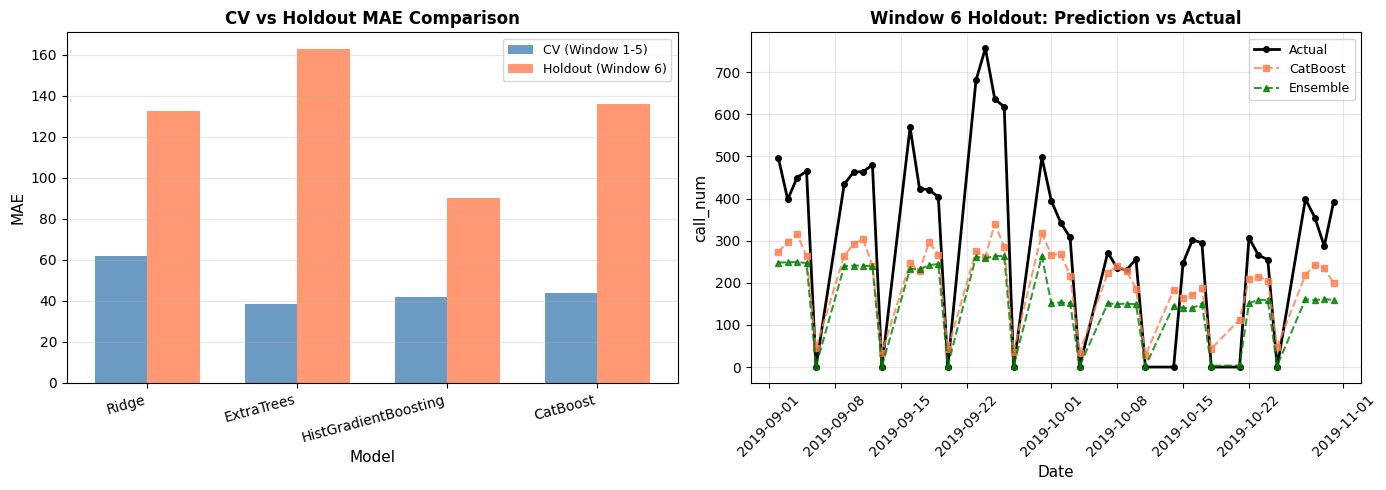


保存: ../output/exp25/exp25_results.png


In [15]:
# ==================================================================================
# 可視化
# ==================================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. CV vs Holdout MAE比較
ax1 = axes[0]
models = comparison_df['model'].tolist()
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, comparison_df['CV_MAE (Window 1-5)'], width, label='CV (Window 1-5)', color='steelblue', alpha=0.8)
ax1.bar(x + width/2, comparison_df['Holdout_MAE (Window 6)'], width, label='Holdout (Window 6)', color='coral', alpha=0.8)
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('MAE', fontsize=11)
ax1.set_title('CV vs Holdout MAE Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3, axis='y')

# 2. Holdout予測 vs 実績
ax2 = axes[1]
test_dates = df_clean[(df_clean['cdr_date'] >= holdout_window['test_start']) & 
                       (df_clean['cdr_date'] <= holdout_window['test_end'])]['cdr_date']
ax2.plot(test_dates.values, y_test_ho.values, 'o-', label='Actual', color='black', linewidth=2, markersize=4)
ax2.plot(test_dates.values, catboost_pred, 's--', label='CatBoost', color='coral', alpha=0.8, markersize=4)
ax2.plot(test_dates.values, ensemble_pred, '^--', label='Ensemble', color='green', alpha=0.8, markersize=4)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('call_num', fontsize=11)
ax2.set_title('Window 6 Holdout: Prediction vs Actual', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/exp25_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n保存: {output_dir}/exp25_results.png")

---
## Summary

**exp25: Window 1-5 CV + Window 6 Holdout + Optuna**

### 構成
- **CV (Window 1-5)**: Optunaでハイパーパラメータ最適化
- **Holdout (Window 6)**: 最終評価（2019-09 ~ 2019-10）
- **リーク防止**: Holdout期間のデータは最適化に一切使用していない

### 評価の流れ
1. Window 1-5 の平均MAEでOptuna最適化（50 trials × 4モデル）
2. アンサンブル重みも Window 1-5 で最適化
3. Window 6 で最終評価（1回のみ）

### 出力ファイル
1. `best_params.json` - 最適化されたパラメータ
2. `holdout_results.csv` - Window 6 の最終結果
3. `cv_vs_holdout.csv` - CV vs Holdout 比較
4. `exp25_results.png` - 可視化